# TimbreNet2 Train

In [1]:
import os
import random
import IPython
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from lib.model import TimbreNet_Model
from lib.specgrams_helper import SpecgramsHelper

os.environ["CUDA_VISIBLE_DEVICES"]="1"
tf.test.is_gpu_available()

True

In [2]:
# run params
time_clock = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
RUN_ID = 'ID_'+time_clock
#RUN_ID = 'ID_2020_06_22_23_02_23'
RUN_FOLDER = './run/{}'.format(RUN_ID)

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))
    os.mkdir(os.path.join(RUN_FOLDER, 'logs'))
    os.mkdir(os.path.join(RUN_FOLDER + '/logs', 'scalars'))

mode =  'build' 
#mode =  'load' 

# Data

In [3]:
LEARNING_RATE = 3e-5
LOSS_TYPE = 'sigma_fixed'
R_LOSS_FACTOR = 10
EPOCHS = 5
PRINT_EVERY_N_BATCHES = 10
INITIAL_EPOCH = 0
SEED = 21
BATCH_SIZE = 10
NUM_TRAIN_IMAGES = 100
NUM_TEST_IMAGES  = 100

# Architecture

In [4]:
LATENT_DIM = 16
TN_VAE = TimbreNet_Model(LATENT_DIM)
if mode == 'build':
    TN_VAE.save(RUN_FOLDER)
else:
    TN_VAE.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))
    
TN_VAE.encoder.summary()
TN_VAE.decoder.summary()

#Select dataset folder
list_train_ds = tf.data.Dataset.list_files('./datasets/pianoTriadDataset/audio_mini_test/*', shuffle=True, seed=SEED)#.batch(BATCH_SIZE)
list_test_ds = tf.data.Dataset.list_files('./datasets/pianoTriadDataset/audio_mini_test/*', shuffle=True, seed=SEED)

#Apply preprocess to the dataset and batch
audio_train_ds = list_train_ds.map(TN_VAE.pre_process).batch(BATCH_SIZE).repeat(EPOCHS)
audio_test_ds  =  list_test_ds.map(TN_VAE.pre_process).batch(1)#BATCH_SIZE)

TN_VAE.compile(LEARNING_RATE, LOSS_TYPE, R_LOSS_FACTOR)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 1024, 2 0                                            
__________________________________________________________________________________________________
encoder_conv_in (Conv2D)        (None, 128, 1024, 32 96          encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_conv_0_1 (Conv2D)       (None, 128, 1024, 32 9248        encoder_conv_in[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 1024, 32 128         encoder_conv_0_1[0][0]           
____________________________________________________________________________________________

# Training

In [5]:
TN_VAE.train_with_generator2(     
    audio_train_ds
    , epochs = EPOCHS
    , steps_per_epoch = NUM_TRAIN_IMAGES / BATCH_SIZE
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , initial_epoch = INITIAL_EPOCH
    , validation_data = audio_test_ds
)

Epoch 1/5
10/10 [==============================] - 31s 3s/step - loss: 1.7388 - vae_r_loss: 1.5160 - vae_kl_loss: 0.2228 - val_loss: 1.4989 - val_vae_r_loss: 1.4987 - val_vae_kl_loss: 2.4199e-04
Epoch 2/5
10/10 [==============================] - 19s 2s/step - loss: 1.6151 - vae_r_loss: 1.4234 - vae_kl_loss: 0.1918 - val_loss: 1.4338 - val_vae_r_loss: 1.4329 - val_vae_kl_loss: 9.0260e-04
Epoch 3/5
10/10 [==============================] - 19s 2s/step - loss: 1.5758 - vae_r_loss: 1.4024 - vae_kl_loss: 0.1734 - val_loss: 1.4324 - val_vae_r_loss: 1.4305 - val_vae_kl_loss: 0.0019
Epoch 4/5
10/10 [==============================] - 19s 2s/step - loss: 1.5537 - vae_r_loss: 1.3992 - vae_kl_loss: 0.1545 - val_loss: 1.4256 - val_vae_r_loss: 1.4223 - val_vae_kl_loss: 0.0033
Epoch 5/5
10/10 [==============================] - 19s 2s/step - loss: 1.5550 - vae_r_loss: 1.3998 - vae_kl_loss: 0.1551 - val_loss: 1.4304 - val_vae_r_loss: 1.4256 - val_vae_kl_loss: 0.0048


# Generate some audios

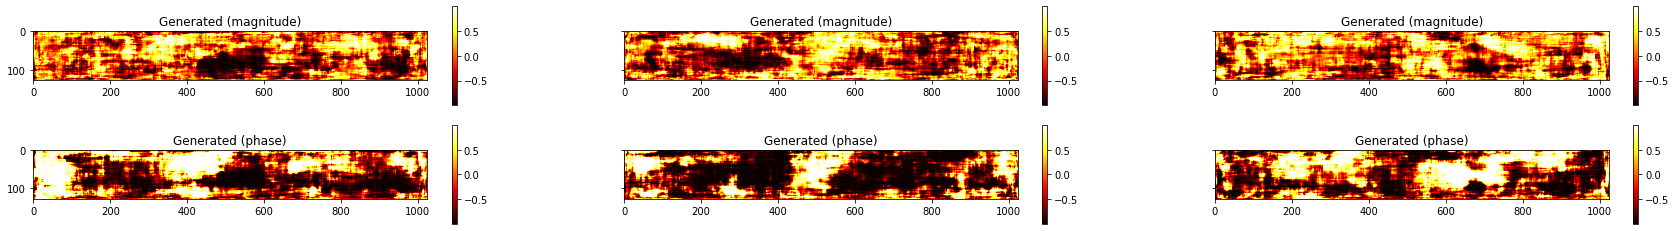

In [6]:
N = 3
audios, mels = TN_VAE.gen_audio_and_spec(z=None, n_to_show=N)
fig, ax = plt.subplots(2, N, sharey=True,figsize=(30,4))
for i in range(N):
    IPython.display.display(IPython.display.Audio(audios[i],rate = 16000,normalize=False))
for i in range(N):  
    p1 = ax[0,i].imshow(mels[i,:,:,0], cmap='hot')
    p1_t = ax[0,i].title.set_text('Generated (magnitude)')
    plt.colorbar(p1,ax=ax[0,i])
    p2 = ax[1,i].imshow(mels[i,:,:,1], cmap='hot')
    p2_t = ax[1,i].title.set_text('Generated (phase)')
    plt.colorbar(p2,ax=ax[1,i])

